In [1]:
import importlib
#from models.base_model import BaseModel


def find_model_using_name(model_name):
    """Import the module "models/[model_name]_model.py".
    In the file, the class called DatasetNameModel() will
    be instantiated. It has to be a subclass of BaseModel,
    and it is case-insensitive.
    """
    model_filename = "models." + model_name + "_model"
    modellib = importlib.import_module(model_filename)
    model = None
    target_model_name = model_name.replace('_', '') + 'model'
    for name, cls in modellib.__dict__.items():
        if name.lower() == target_model_name.lower() \
           and issubclass(cls, BaseModel):
            model = cls

    if model is None:
        print("In %s.py, there should be a subclass of BaseModel with class name that matches %s in lowercase." % (model_filename, target_model_name))
        exit(0)

    return model


def get_option_setter(model_name):
    """Return the static method <modify_commandline_options> of the model class."""
    model_class = find_model_using_name(model_name)
    return model_class.modify_commandline_options


def create_model(opt):
    """Create a model given the option.
    This function warps the class CustomDatasetDataLoader.
    This is the main interface between this package and 'train.py'/'test.py'
    Example:
        >>> from models import create_model
        >>> model = create_model(opt)
    """
    model = find_model_using_name(opt.model)
    instance = model(opt)
    print("model [%s] was created" % type(instance).__name__)
    return instance

In [2]:
import random
import torch


class ImagePool():
    """This class implements an image buffer that stores previously generated images.
    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """

    def __init__(self, pool_size):
        """Initialize the ImagePool class
        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Return an image from the pool.
        Parameters:
            images: the latest generated images from the generator
        Returns images from the buffer.
        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

In [3]:
import os
import torch
from collections import OrderedDict
from abc import ABC, abstractmethod
#from . import networks


class BaseModel(ABC):
    """This class is an abstract base class (ABC) for models.
    To create a subclass, you need to implement the following five functions:
        -- <__init__>:                      initialize the class; first call BaseModel.__init__(self, opt).
        -- <set_input>:                     unpack data from dataset and apply preprocessing.
        -- <forward>:                       produce intermediate results.
        -- <optimize_parameters>:           calculate losses, gradients, and update network weights.
        -- <modify_commandline_options>:    (optionally) add model-specific options and set default options.
    """

    def __init__(self, opt):
        """Initialize the BaseModel class.
        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        When creating your custom class, you need to implement your own initialization.
        In this fucntion, you should first call <BaseModel.__init__(self, opt)>
        Then, you need to define four lists:
            -- self.loss_names (str list):          specify the training losses that you want to plot and save.
            -- self.model_names (str list):         specify the images that you want to display and save.
            -- self.visual_names (str list):        define networks used in our training.
            -- self.optimizers (optimizer list):    define and initialize optimizers. You can define one optimizer for each network. If two networks are updated at the same time, you can use itertools.chain to group them. See cycle_gan_model.py for an example.
        """
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')  # get device name: CPU or GPU
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)  # save all the checkpoints to save_dir
        if opt.preprocess != 'scale_width':  # with [scale_width], input images might have different sizes, which hurts the performance of cudnn.benchmark.
            torch.backends.cudnn.benchmark = True
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.optimizers = []
        self.image_paths = []
        self.metric = 0  # used for learning rate policy 'plateau'

    @staticmethod
    def modify_commandline_options(parser, is_train):
        """Add new model-specific options, and rewrite default values for existing options.
        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.
        Returns:
            the modified parser.
        """
        return parser

    @abstractmethod
    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.
        Parameters:
            input (dict): includes the data itself and its metadata information.
        """
        pass

    @abstractmethod
    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        pass

    @abstractmethod
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        pass

    def setup(self, opt):
        """Load and print networks; create schedulers
        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        if self.isTrain:
            self.schedulers = [networks.get_scheduler(optimizer, opt) for optimizer in self.optimizers]
        if not self.isTrain or opt.continue_train:
            load_suffix = 'iter_%d' % opt.load_iter if opt.load_iter > 0 else opt.epoch
            self.load_networks(load_suffix)
        self.print_networks(opt.verbose)

    def eval(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                net.eval()

    def test(self):
        """Forward function used in test time.
        This function wraps <forward> function in no_grad() so we don't save intermediate steps for backprop
        It also calls <compute_visuals> to produce additional visualization results
        """
        with torch.no_grad():
            self.forward()
            self.compute_visuals()

    def compute_visuals(self):
        """Calculate additional output images for visdom and HTML visualization"""
        pass

    def get_image_paths(self):
        """ Return image paths that are used to load current data"""
        return self.image_paths

    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        for scheduler in self.schedulers:
            if self.opt.lr_policy == 'plateau':
                scheduler.step(self.metric)
            else:
                scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate = %.7f' % lr)

    def get_current_visuals(self):
        """Return visualization images. train.py will display these images with visdom, and save the images to a HTML"""
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret

    def save_networks(self, epoch):
        """Save all the networks to the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)

    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    def load_networks(self, epoch):
        """Load all the networks from the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)

    def print_networks(self, verbose):
        """Print the total number of parameters in the network and (if verbose) network architecture
        Parameters:
            verbose (bool) -- if verbose: print the network architecture
        """
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
        print('-----------------------------------------------')

    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [4]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import torch.nn.functional as F


###############################################################################
# Helper Functions
###############################################################################


class Identity(nn.Module):
    def forward(self, x):
        return x


def get_norm_layer(norm_type='instance'):
    """Return a normalization layer
    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none
    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        norm_layer = lambda x: Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler
    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine
    For 'linear', we keep the same learning rate for the first <opt.niter> epochs
    and linearly decay the rate to zero over the next <opt.niter_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt.lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.niter, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        # print(net)
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator
    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Returns a generator
    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597
        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).
    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'our':
        net = ResnetGenerator_our(input_nc, output_nc, ngf, n_blocks=9)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator
    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Returns a discriminator
    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.
        [n_layers]: With this mode, you cna specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)
        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.
    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)


##############################################################################
# Classes
##############################################################################
class GANLoss(nn.Module):
    """Define different GAN objectives.
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.
        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.
        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028
    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( | |gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss
    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

class ResnetGenerator_our(nn.Module):
    # initializers
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        super(ResnetGenerator_our, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.nb = n_blocks
        self.conv1 = nn.Conv2d(input_nc, ngf, 7, 1, 0)
        self.conv1_norm = nn.InstanceNorm2d(ngf)
        self.conv2 = nn.Conv2d(ngf, ngf * 2, 3, 2, 1)
        self.conv2_norm = nn.InstanceNorm2d(ngf * 2)
        self.conv3 = nn.Conv2d(ngf * 2, ngf * 4, 3, 2, 1)
        self.conv3_norm = nn.InstanceNorm2d(ngf * 4)

        self.resnet_blocks = []
        for i in range(n_blocks):
            self.resnet_blocks.append(resnet_block(ngf * 4, 3, 1, 1))
            self.resnet_blocks[i].weight_init(0, 0.02)

        self.resnet_blocks = nn.Sequential(*self.resnet_blocks)

        # self.resnet_blocks1 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks1.weight_init(0, 0.02)
        # self.resnet_blocks2 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks2.weight_init(0, 0.02)
        # self.resnet_blocks3 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks3.weight_init(0, 0.02)
        # self.resnet_blocks4 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks4.weight_init(0, 0.02)
        # self.resnet_blocks5 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks5.weight_init(0, 0.02)
        # self.resnet_blocks6 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks6.weight_init(0, 0.02)
        # self.resnet_blocks7 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks7.weight_init(0, 0.02)
        # self.resnet_blocks8 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks8.weight_init(0, 0.02)
        # self.resnet_blocks9 = resnet_block(256, 3, 1, 1)
        # self.resnet_blocks9.weight_init(0, 0.02)

        self.deconv1_content = nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, 1)
        self.deconv1_norm_content = nn.InstanceNorm2d(ngf * 2)
        self.deconv2_content = nn.ConvTranspose2d(ngf * 2, ngf, 3, 2, 1, 1)
        self.deconv2_norm_content = nn.InstanceNorm2d(ngf)
        self.deconv3_content = nn.Conv2d(ngf, 30, 7, 1, 0)

        self.deconv1_attention = nn.ConvTranspose2d(ngf * 4, ngf * 2, 3, 2, 1, 1)
        self.deconv1_norm_attention = nn.InstanceNorm2d(ngf * 2)
        self.deconv2_attention = nn.ConvTranspose2d(ngf * 2, ngf, 3, 2, 1, 1)
        self.deconv2_norm_attention = nn.InstanceNorm2d(ngf)
        self.deconv3_attention = nn.Conv2d(ngf, 10, 1, 1, 0)
        
        self.tanh = torch.nn.Tanh()
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.pad(input, (3, 3, 3, 3), 'reflect')
        x = F.relu(self.conv1_norm(self.conv1(x)))
        x = F.relu(self.conv2_norm(self.conv2(x)))
        x = F.relu(self.conv3_norm(self.conv3(x)))
        x = self.resnet_blocks(x)
        # x = self.resnet_blocks1(x)
        # x = self.resnet_blocks2(x)
        # x = self.resnet_blocks3(x)
        # x = self.resnet_blocks4(x)
        # x = self.resnet_blocks5(x)
        # x = self.resnet_blocks6(x)
        # x = self.resnet_blocks7(x)
        # x = self.resnet_blocks8(x)
        # x = self.resnet_blocks9(x)
        x_content = F.relu(self.deconv1_norm_content(self.deconv1_content(x)))
        x_content = F.relu(self.deconv2_norm_content(self.deconv2_content(x_content)))
        x_content = F.pad(x_content, (3, 3, 3, 3), 'reflect')
        content = self.deconv3_content(x_content)
        image = self.tanh(content)
        image1 = image[:, 0:3, :, :]
        # print(image1.size()) # [1, 3, 256, 256]
        image2 = image[:, 3:6, :, :]
        image3 = image[:, 6:9, :, :]
        image4 = image[:, 9:12, :, :]
        image5 = image[:, 12:15, :, :]
        image6 = image[:, 15:18, :, :]
        image7 = image[:, 18:21, :, :]
        image8 = image[:, 21:24, :, :]
        image9 = image[:, 24:27, :, :]
        # image10 = image[:, 27:30, :, :]

        x_attention = F.relu(self.deconv1_norm_attention(self.deconv1_attention(x)))
        x_attention = F.relu(self.deconv2_norm_attention(self.deconv2_attention(x_attention)))
        # x_attention = F.pad(x_attention, (3, 3, 3, 3), 'reflect')
        # print(x_attention.size()) [1, 64, 256, 256]
        attention = self.deconv3_attention(x_attention)

        softmax_ = torch.nn.Softmax(dim=1)
        attention = softmax_(attention)

        attention1_ = attention[:, 0:1, :, :]
        attention2_ = attention[:, 1:2, :, :]
        attention3_ = attention[:, 2:3, :, :]
        attention4_ = attention[:, 3:4, :, :]
        attention5_ = attention[:, 4:5, :, :]
        attention6_ = attention[:, 5:6, :, :]
        attention7_ = attention[:, 6:7, :, :]
        attention8_ = attention[:, 7:8, :, :]
        attention9_ = attention[:, 8:9, :, :]
        attention10_ = attention[:, 9:10, :, :]

        attention1 = attention1_.repeat(1, 3, 1, 1)
        # print(attention1.size())
        attention2 = attention2_.repeat(1, 3, 1, 1)
        attention3 = attention3_.repeat(1, 3, 1, 1)
        attention4 = attention4_.repeat(1, 3, 1, 1)
        attention5 = attention5_.repeat(1, 3, 1, 1)
        attention6 = attention6_.repeat(1, 3, 1, 1)
        attention7 = attention7_.repeat(1, 3, 1, 1)
        attention8 = attention8_.repeat(1, 3, 1, 1)
        attention9 = attention9_.repeat(1, 3, 1, 1)
        attention10 = attention10_.repeat(1, 3, 1, 1)

        output1 = image1 * attention1
        output2 = image2 * attention2
        output3 = image3 * attention3
        output4 = image4 * attention4
        output5 = image5 * attention5
        output6 = image6 * attention6
        output7 = image7 * attention7
        output8 = image8 * attention8
        output9 = image9 * attention9
        # output10 = image10 * attention10
        output10 = input * attention10

        o=output1 + output2 + output3 + output4 + output5 + output6 + output7 + output8 + output9 + output10

        return o, output1, output2, output3, output4, output5, output6, output7, output8, output9, output10, attention1,attention2,attention3, attention4, attention5, attention6, attention7, attention8,attention9,attention10, image1, image2,image3,image4,image5,image6,image7,image8,image9

# resnet block with reflect padding
class resnet_block(nn.Module):
    def __init__(self, channel, kernel, stride, padding):
        super(resnet_block, self).__init__()
        self.channel = channel
        self.kernel = kernel
        self.strdie = stride
        self.padding = padding
        self.conv1 = nn.Conv2d(channel, channel, kernel, stride, 0)
        self.conv1_norm = nn.InstanceNorm2d(channel)
        self.conv2 = nn.Conv2d(channel, channel, kernel, stride, 0)
        self.conv2_norm = nn.InstanceNorm2d(channel)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input):
        x = F.pad(input, (self.padding, self.padding, self.padding, self.padding), 'reflect')
        x = F.relu(self.conv1_norm(self.conv1(x)))
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding), 'reflect')
        x = self.conv2_norm(self.conv2(x))

        return input + x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            user_dropout (bool) -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


class PixelDiscriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)

In [5]:
import importlib
import torch.utils.data
#from data.base_dataset import BaseDataset


def find_dataset_using_name(dataset_name):
    """Import the module "data/[dataset_name]_dataset.py".
    In the file, the class called DatasetNameDataset() will
    be instantiated. It has to be a subclass of BaseDataset,
    and it is case-insensitive.
    """
    dataset_filename = "data." + dataset_name + "_dataset"
    datasetlib = importlib.import_module(dataset_filename)

    dataset = None
    target_dataset_name = dataset_name.replace('_', '') + 'dataset'
    for name, cls in datasetlib.__dict__.items():
        if name.lower() == target_dataset_name.lower() \
           and issubclass(cls, BaseDataset):
            dataset = cls

    if dataset is None:
        raise NotImplementedError("In %s.py, there should be a subclass of BaseDataset with class name that matches %s in lowercase." % (dataset_filename, target_dataset_name))

    return dataset


def get_option_setter(dataset_name):
    """Return the static method <modify_commandline_options> of the dataset class."""
    dataset_class = find_dataset_using_name(dataset_name)
    return dataset_class.modify_commandline_options


def create_dataset(opt):
    """Create a dataset given the option.
    This function wraps the class CustomDatasetDataLoader.
        This is the main interface between this package and 'train.py'/'test.py'
    Example:
        >>> from data import create_dataset
        >>> dataset = create_dataset(opt)
    """
    data_loader = CustomDatasetDataLoader(opt)
    dataset = data_loader.load_data()
    return dataset


class CustomDatasetDataLoader():
    """Wrapper class of Dataset class that performs multi-threaded data loading"""

    def __init__(self, opt):
        """Initialize this class
        Step 1: create a dataset instance given the name [dataset_mode]
        Step 2: create a multi-threaded data loader.
        """
        self.opt = opt
        dataset_class = find_dataset_using_name(opt.dataset_mode)
        self.dataset = dataset_class(opt)
        print("dataset [%s] was created" % type(self.dataset).__name__)
        self.dataloader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=opt.batch_size,
            shuffle=not opt.serial_batches,
            num_workers=int(opt.num_threads))

    def load_data(self):
        return self

    def __len__(self):
        """Return the number of data in the dataset"""
        return min(len(self.dataset), self.opt.max_dataset_size)

    def __iter__(self):
        """Return a batch of data"""
        for i, data in enumerate(self.dataloader):
            if i * self.opt.batch_size >= self.opt.max_dataset_size:
                break
            yield data

In [6]:
import random
import numpy as np
import torch.utils.data as data
from PIL import Image
import torchvision.transforms as transforms
from abc import ABC, abstractmethod


class BaseDataset(data.Dataset, ABC):
    """This class is an abstract base class (ABC) for datasets.
    To create a subclass, you need to implement the following four functions:
    -- <__init__>:                      initialize the class, first call BaseDataset.__init__(self, opt).
    -- <__len__>:                       return the size of dataset.
    -- <__getitem__>:                   get a data point.
    -- <modify_commandline_options>:    (optionally) add dataset-specific options and set default options.
    """

    def __init__(self, opt):
        """Initialize the class; save the options in the class
        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        self.opt = opt
        self.root = opt.dataroot

    @staticmethod
    def modify_commandline_options(parser, is_train):
        """Add new dataset-specific options, and rewrite default values for existing options.
        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.
        Returns:
            the modified parser.
        """
        return parser

    @abstractmethod
    def __len__(self):
        """Return the total number of images in the dataset."""
        return 0

    @abstractmethod
    def __getitem__(self, index):
        """Return a data point and its metadata information.
        Parameters:
            index - - a random integer for data indexing
        Returns:
            a dictionary of data with their names. It ususally contains the data itself and its metadata information.
        """
        pass


def get_params(opt, size):
    w, h = size
    new_h = h
    new_w = w
    if opt.preprocess == 'resize_and_crop':
        new_h = new_w = opt.load_size
    elif opt.preprocess == 'scale_width_and_crop':
        new_w = opt.load_size
        new_h = opt.load_size * h // w

    x = random.randint(0, np.maximum(0, new_w - opt.crop_size))
    y = random.randint(0, np.maximum(0, new_h - opt.crop_size))

    flip = random.random() > 0.5

    return {'crop_pos': (x, y), 'flip': flip}


def get_transform(opt, params=None, grayscale=False, method=Image.BICUBIC, convert=True):
    transform_list = []
    if grayscale:
        transform_list.append(transforms.Grayscale(1))
    if 'resize' in opt.preprocess:
        osize = [opt.load_size, opt.load_size]
        transform_list.append(transforms.Resize(osize, method))
    elif 'scale_width' in opt.preprocess:
        transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt.load_size, method)))

    if 'crop' in opt.preprocess:
        if params is None:
            transform_list.append(transforms.RandomCrop(opt.crop_size))
        else:
            transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], opt.crop_size)))

    if opt.preprocess == 'none':
        transform_list.append(transforms.Lambda(lambda img: __make_power_2(img, base=4, method=method)))

    if not opt.no_flip:
        if params is None:
            transform_list.append(transforms.RandomHorizontalFlip())
        elif params['flip']:
            transform_list.append(transforms.Lambda(lambda img: __flip(img, params['flip'])))

    if convert:
        transform_list += [transforms.ToTensor()]
        if grayscale:
            transform_list += [transforms.Normalize((0.5,), (0.5,))]
        else:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)


def __make_power_2(img, base, method=Image.BICUBIC):
    ow, oh = img.size
    h = int(round(oh / base) * base)
    w = int(round(ow / base) * base)
    if (h == oh) and (w == ow):
        return img

    __print_size_warning(ow, oh, w, h)
    return img.resize((w, h), method)


def __scale_width(img, target_width, method=Image.BICUBIC):
    ow, oh = img.size
    if (ow == target_width):
        return img
    w = target_width
    h = int(target_width * oh / ow)
    return img.resize((w, h), method)


def __crop(img, pos, size):
    ow, oh = img.size
    x1, y1 = pos
    tw = th = size
    if (ow > tw or oh > th):
        return img.crop((x1, y1, x1 + tw, y1 + th))
    return img


def __flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img


def __print_size_warning(ow, oh, w, h):
    """Print warning information about image size(only print once)"""
    if not hasattr(__print_size_warning, 'has_printed'):
        print("The image size needs to be a multiple of 4. "
              "The loaded image size was (%d, %d), so it was adjusted to "
              "(%d, %d). This adjustment will be done to all images "
              "whose sizes are not multiples of 4" % (ow, oh, w, h))
        __print_size_warning.has_printed = True

In [7]:
import torch.utils.data as data

from PIL import Image
import os
import os.path

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir, max_dataset_size=float("inf")):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images[:min(max_dataset_size, len(images))]


def default_loader(path):
    return Image.open(path).convert('RGB')


class ImageFolder(data.Dataset):

    def __init__(self, root, transform=None, return_paths=False,
                 loader=default_loader):
        imgs = make_dataset(root)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in: " + root + "\n"
                               "Supported image extensions are: " +
                               ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.transform = transform
        self.return_paths = return_paths
        self.loader = loader

    def __getitem__(self, index):
        path = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.return_paths:
            return img, path
        else:
            return img

    def __len__(self):
        return len(self.imgs)

In [8]:
import os.path
#from data.base_dataset import BaseDataset, get_transform
#from data.image_folder import make_dataset
from PIL import Image
import random


class UnalignedDataset(BaseDataset):
    """
    This dataset class can load unaligned/unpaired datasets.
    It requires two directories to host training images from domain A '/path/to/data/trainA'
    and from domain B '/path/to/data/trainB' respectively.
    You can train the model with the dataset flag '--dataroot /path/to/data'.
    Similarly, you need to prepare two directories:
    '/path/to/data/testA' and '/path/to/data/testB' during test time.
    """

    def __init__(self, opt):
        """Initialize this dataset class.
        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseDataset.__init__(self, opt)
        self.dir_A = os.path.join(opt.dataroot, opt.phase + 'A')  # create a path '/path/to/data/trainA'
        self.dir_B = os.path.join(opt.dataroot, opt.phase + 'B')  # create a path '/path/to/data/trainB'

        self.A_paths = sorted(make_dataset(self.dir_A, opt.max_dataset_size))   # load images from '/path/to/data/trainA'
        self.B_paths = sorted(make_dataset(self.dir_B, opt.max_dataset_size))    # load images from '/path/to/data/trainB'
        self.A_size = len(self.A_paths)  # get the size of dataset A
        self.B_size = len(self.B_paths)  # get the size of dataset B
        btoA = self.opt.direction == 'BtoA'
        input_nc = self.opt.output_nc if btoA else self.opt.input_nc       # get the number of channels of input image
        output_nc = self.opt.input_nc if btoA else self.opt.output_nc      # get the number of channels of output image
        self.transform_A = get_transform(self.opt, grayscale=(input_nc == 1))
        self.transform_B = get_transform(self.opt, grayscale=(output_nc == 1))

    def __getitem__(self, index):
        """Return a data point and its metadata information.
        Parameters:
            index (int)      -- a random integer for data indexing
        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor)       -- an image in the input domain
            B (tensor)       -- its corresponding image in the target domain
            A_paths (str)    -- image paths
            B_paths (str)    -- image paths
        """
        A_path = self.A_paths[index % self.A_size]  # make sure index is within then range
        if self.opt.serial_batches:   # make sure index is within then range
            index_B = index % self.B_size
        else:   # randomize the index for domain B to avoid fixed pairs.
            index_B = random.randint(0, self.B_size - 1)
        B_path = self.B_paths[index_B]
        A_img = Image.open(A_path).convert('RGB')
        B_img = Image.open(B_path).convert('RGB')
        # apply image transformation
        A = self.transform_A(A_img)
        B = self.transform_B(B_img)

        return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}

    def __len__(self):
        """Return the total number of images in the dataset.
        As we have two datasets with potentially different number of images,
        we take a maximum of
        """
        return max(self.A_size, self.B_size)

In [10]:
import torch
import itertools
#from util.image_pool import ImagePool
#from .base_model import BaseModel
#from . import networks


class AttentionGANModel():

    def __init__(self):
        self.optimizers=[]
        #BaseModel.__init__(self)
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        #self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        #visual_names_A = ['real_A', 'fake_B', 'rec_A', 'o1_b', 'o2_b', 'o3_b', 'o4_b', 'o5_b', 'o6_b', 'o7_b', 'o8_b', 'o9_b', 'o10_b',
        #'a1_b', 'a2_b', 'a3_b', 'a4_b', 'a5_b', 'a6_b', 'a7_b', 'a8_b', 'a9_b', 'a10_b', 'i1_b', 'i2_b', 'i3_b', 'i4_b', 'i5_b', 
        #'i6_b', 'i7_b', 'i8_b', 'i9_b']
        #visual_names_B = ['real_B', 'fake_A', 'rec_B', 'o1_a', 'o2_a', 'o3_a', 'o4_a', 'o5_a', 'o6_a', 'o7_a', 'o8_a', 'o9_a', 'o10_a', 
        #'a1_a', 'a2_a', 'a3_a', 'a4_a', 'a5_a', 'a6_a', 'a7_a', 'a8_a', 'a9_a', 'a10_a', 'i1_a', 'i2_a', 'i3_a', 'i4_a', 'i5_a', 
        #'i6_a', 'i7_a', 'i8_a', 'i9_a']
        

        
        # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>.
        #if self.isTrain:
        #    self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        #else:  # during test time, only load Gs
        #    self.model_names = ['G_A', 'G_B']

        # define networks (both Generators and discriminators)
        # The naming is different from those used in the paper.
        # Code (vs. paper): G_A (G), G_B (F), D_A (D_Y), D_B (D_X)
        
        #netGA = ResnetGenerator_our(3, 3, 64, n_blocks=9)
        #netGB = ResnetGenerator_our(3, 3, 64, n_blocks=9)
        #netDA = NLayerDiscriminator(3, 64, n_layers=3, norm_layer=functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False))
        #netDB = NLayerDiscriminator(3, 64, n_layers=3, norm_layer=functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False))

        self.netG_A = ResnetGenerator_our(3, 3, 64, n_blocks=9).to(device)
        self.netG_B = ResnetGenerator_our(3, 3, 64, n_blocks=9).to(device)

        self.netD_A = NLayerDiscriminator(3, 64, n_layers=3, norm_layer=functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)).to(device)

        self.netD_B = NLayerDiscriminator(3, 64, n_layers=3, norm_layer=functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)).to(device)


        #if self.isTrain:
        #    if opt.lambda_identity > 0.0:  # only works when input and output images have the same number of channels
        #        assert(opt.input_nc == opt.output_nc)
        self.fake_A_pool = ImagePool(50)  # create image buffer to store previously generated images
        self.fake_B_pool = ImagePool(50)  # create image buffer to store previously generated images
        # define loss functions
        self.criterionGAN = GANLoss('lsgan').to(device)  # define GAN loss.
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()
        # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
        self.optimizers.append(self.optimizer_G)
        self.optimizers.append(self.optimizer_D)

    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.
        Parameters:
            input (dict): include the data itself and its metadata information.
        The option 'direction' can be used to swap domain A and domain B.
        """
        AtoB = True #self.opt.direction == 'AtoB'
        self.real_A = input['A' if AtoB else 'B'].to(device)
        self.real_B = input['B' if AtoB else 'A'].to(device)
        #self.image_paths = input['A_paths' if AtoB else 'B_paths']

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B, self.o1_b, self.o2_b, self.o3_b, self.o4_b, self.o5_b, self.o6_b, self.o7_b, self.o8_b, self.o9_b, self.o10_b, \
        self.a1_b, self.a2_b, self.a3_b, self.a4_b, self.a5_b, self.a6_b, self.a7_b, self.a8_b, self.a9_b, self.a10_b, \
        self.i1_b, self.i2_b, self.i3_b, self.i4_b, self.i5_b, self.i6_b, self.i7_b, self.i8_b, self.i9_b = self.netG_A(self.real_A)  # G_A(A)
        self.rec_A, _, _, _, _, _, _, _, _, _, _, \
        _, _, _, _, _, _, _, _, _, _, \
        _, _, _, _, _, _, _, _, _ = self.netG_B(self.fake_B)   # G_B(G_A(A))
        self.fake_A, self.o1_a, self.o2_a, self.o3_a, self.o4_a, self.o5_a, self.o6_a, self.o7_a, self.o8_a, self.o9_a, self.o10_a, \
        self.a1_a, self.a2_a, self.a3_a, self.a4_a, self.a5_a, self.a6_a, self.a7_a, self.a8_a, self.a9_a, self.a10_a, \
        self.i1_a, self.i2_a, self.i3_a, self.i4_a, self.i5_a, self.i6_a, self.i7_a, self.i8_a, self.i9_a = self.netG_B(self.real_B)  # G_B(B)
        self.rec_B, _, _, _, _, _, _, _, _, _, _, \
        _, _, _, _, _, _, _, _, _, _, \
        _, _, _, _, _, _, _, _, _ = self.netG_A(self.fake_A)   # G_A(G_B(B))

    def backward_D_basic(self, netD, real, fake):
        """Calculate GAN loss for the discriminator
        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator
        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D

    def backward_D_A(self):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B)

    def backward_D_B(self):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A)

    def backward_G(self):
        """Calculate the loss for generators G_A and G_B"""
        lambda_idt = 0.5 #self.opt.lambda_identity
        lambda_A = 0.1 #self.opt.lambda_A
        lambda_B = 0.1 #self.opt.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            self.idt_A, _, _, _, _, _, _, _, _, _, _, \
            _, _, _, _, _, _, _, _, _, _, \
            _, _, _, _, _, _, _, _, _  = self.netG_A(self.real_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            self.idt_B, _, _, _, _, _, _, _, _, _, _, \
            _, _, _, _, _, _, _, _, _, _, \
            _, _, _, _, _, _, _, _, _  = self.netG_B(self.real_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B
        self.loss_G.backward()

    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
        self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights
        
    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import torch
from torchvision import datasets
from torchvision import transforms


transform = transforms.Compose([
                transforms.Resize((256,256)),
                #transforms.CenterCrop((224,224)),
                #transforms.ToPILImage(),
                #transforms.RandomVerticalFlip(),
                #transforms.RandomHorizontalFlip,
                transforms.ToTensor()])

trainA = datasets.ImageFolder('/content/drive/My Drive/dataA', transform=transform)
trainB = datasets.ImageFolder('/content/drive/My Drive/dataA', transform=transform)

trainloaderA = torch.utils.data.DataLoader(trainA, batch_size=2, shuffle=True)
trainloaderB = torch.utils.data.DataLoader(trainB, batch_size=2, shuffle=True)



In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.cuda.empty_cache()

In [14]:
kk=AttentionGANModel()

In [15]:
kk1=AttentionGANModel()

In [16]:
kk2=AttentionGANModel()

In [17]:
kk3=AttentionGANModel()

In [18]:
kk4=AttentionGANModel()

In [19]:

!wget -N http://disi.unitn.it/~hao.tang/uploads/models/AttentionGAN/selfie2anime_pretrained.tar.gz

--2020-06-22 14:28:41--  http://disi.unitn.it/~hao.tang/uploads/models/AttentionGAN/selfie2anime_pretrained.tar.gz
Resolving disi.unitn.it (disi.unitn.it)... 193.205.194.4
Connecting to disi.unitn.it (disi.unitn.it)|193.205.194.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87848644 (84M) [application/x-gzip]
Saving to: ‘selfie2anime_pretrained.tar.gz’

selfie2anime_pretra 100%[===================>]  83.78M  10.1MB/s    in 10s     

2020-06-22 14:28:53 (8.09 MB/s) - ‘selfie2anime_pretrained.tar.gz’ saved [87848644/87848644]



In [20]:
!mkdir model
!tar -zxvf /content/selfie2anime_pretrained.tar.gz  -C model

selfie2anime_pretrained/
selfie2anime_pretrained/latest_net_G_A.pth
selfie2anime_pretrained/latest_net_G_B.pth


In [21]:
netG_A = torch.load('/content/model/selfie2anime_pretrained/latest_net_G_A.pth')
netG_B = torch.load('/content/model/selfie2anime_pretrained/latest_net_G_B.pth')

In [ ]:
netG_A['deconv3_content.weight'].shape

torch.Size([30, 64, 7, 7])

In [ ]:
kk.netG_A.deconv3_content

Conv2d(64, 30, kernel_size=(7, 7), stride=(1, 1))

In [22]:
kk.netG_A.load_state_dict(netG_A)

<All keys matched successfully>

In [23]:
kk.netG_B.load_state_dict(netG_B)

<All keys matched successfully>

In [24]:
kk.netG_A.to(device)
kk.netG_B.to(device)

ResnetGenerator_our(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv1_norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (resnet_blocks): Sequential(
    (0): resnet_block(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (conv1_norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (conv2_norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (1): resnet_block(
      (conv1): Conv2d(256, 2

In [ ]:
import pickle
epochs=5
path='/content/drive/My Drive/kkTcycle_1.pth'
for epoch in range(epochs):
  B=iter(trainloaderB)
  for i, A in enumerate(trainloaderA):
    dA,_=A
    dB,_=next(B)
    kk.set_input({"A":dA,"B":dB})
    kk.optimize_parameters()
    if(i%200==0):
      print(epoch)
      rrr=str(kk.loss_D_B.item())+" "+str(kk.loss_D_A.item())+" "+str(kk.loss_G_A.item())+" "+str(kk.loss_G_B.item())
      print(rrr)
  # pickle.dump(kk,open(path,'wb'))

0
0.6722019910812378 0.7166749835014343 1.2593348026275635 1.243369221687317
0
0.2963581681251526 0.2469376027584076 0.2540617287158966 0.3152081370353699
1
0.2671881914138794 0.2455051839351654 0.2279072105884552 0.27643561363220215
1
0.25562334060668945 0.27393609285354614 0.3064842224121094 0.23752272129058838
2
0.25473469495773315 0.26863911747932434 0.24483045935630798 0.2885211110115051
2
0.2924883961677551 0.2535526156425476 0.2536563277244568 0.3028506636619568
3
0.2511117458343506 0.2632569372653961 0.22409169375896454 0.23790714144706726
3
0.24356654286384583 0.2810424566268921 0.2629013955593109 0.27619668841362
4
0.2608681917190552 0.2743680477142334 0.28355926275253296 0.28248608112335205
4
0.25080764293670654 0.26796334981918335 0.25817999243736267 0.29606351256370544


In [72]:
import pickle
kk1=pickle.load(open('/content/drive/My Drive/Copy of kk','rb'))
kk2=pickle.load(open('/content/drive/My Drive/kkcycle_0.01_20.pth','rb'))
kk3=pickle.load(open('/content/drive/My Drive/kkcycle40_0.5_0.1.pth','rb'))
kk4=pickle.load(open('/content/drive/My Drive/kkcycle40_1_0.5.pth','rb'))


# kk2=pickle.load(open('/content/drive/My Drive/kkcycle_0.5_20.pth','rb'))


torch.Size([2, 3, 256, 256])


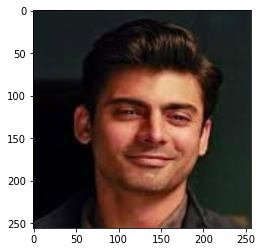

In [120]:
import matplotlib.pyplot as plt
image,_=next(iter(trainloaderA))
print(image.shape)
plt.imshow(image[0].numpy().transpose(1,2,0))

In [ ]:
ffff=kk.netG_A(image.to(device))
ffff1=kk1.netG_A(image.to(device))
ffff2=kk2.netG_A(image.to(device))
ffff3=kk3.netG_A(image.to(device))
ffff4=kk4.netG_A(image.to(device))

fig=plt.figure(figsize=(25, 25))

fig.add_subplot(1, 6, 1)
plt.imshow(image[0].numpy().transpose(1,2,0))

fig.add_subplot(1, 6, 2)
plt.imshow(ffff[0][0].detach().cpu().numpy().transpose(1,2,0))

fig.add_subplot(1, 6, 3)
plt.imshow(ffff1[0][0].detach().cpu().numpy().transpose(1,2,0))

fig.add_subplot(1, 6, 4)
plt.imshow(ffff2[0][0].detach().cpu().numpy().transpose(1,2,0))

fig.add_subplot(1, 6,5)
plt.imshow(ffff3[0][0].detach().cpu().numpy().transpose(1,2,0))

fig.add_subplot(1, 6, 6)
plt.imshow(ffff4[0][0].detach().cpu().numpy().transpose(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 0])


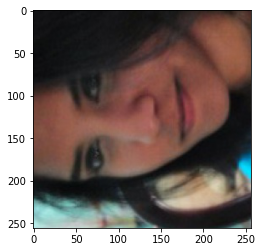

In [ ]:
image,qq=next(iter(trainloaderA))
print(qq)
plt.imshow(image[0].numpy().transpose(2,1,0))

In [ ]:
!unzip /content/horse2zebra.zip -d ./datasets/

In [ ]:
!unzip "/content/drive/My Drive/Copy of selfie2anime.zip" -d ./datasets/

Streaming output truncated to the last 5000 lines.
  inflating: ./datasets/trainA/female_26076.jpg  
  inflating: ./datasets/trainA/female_26092.jpg  
  inflating: ./datasets/trainA/female_26125.jpg  
  inflating: ./datasets/trainA/female_26139.jpg  
  inflating: ./datasets/trainA/female_26145.jpg  
  inflating: ./datasets/trainA/female_26149.jpg  
  inflating: ./datasets/trainA/female_26157.jpg  
  inflating: ./datasets/trainA/female_26167.jpg  
  inflating: ./datasets/trainA/female_26181.jpg  
  inflating: ./datasets/trainA/female_26190.jpg  
  inflating: ./datasets/trainA/female_26195.jpg  
  inflating: ./datasets/trainA/female_26219.jpg  
  inflating: ./datasets/trainA/female_26223.jpg  
  inflating: ./datasets/trainA/female_26226.jpg  
  inflating: ./datasets/trainA/female_26227.jpg  
  inflating: ./datasets/trainA/female_26231.jpg  
  inflating: ./datasets/trainA/female_26239.jpg  
  inflating: ./datasets/trainA/female_26241.jpg  
  inflating: ./datasets/trainA/female_26247.jpg  

In [ ]:
!mkdir /content/datasets/selfie/

In [ ]:
!mkdir /content/datasets/anime/

In [ ]:
!mv /content/datasets/trainA /content/datasets/selfie

In [ ]:
!mv /content/datasets/trainB /content/datasets/anime

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms


transform = transforms.Compose([
                transforms.Resize((256,256)),
                #transforms.CenterCrop((224,224)),
                #transforms.ToPILImage(),
                transforms.RandomVerticalFlip(),
                #transforms.RandomHorizontalFlip,
                transforms.ToTensor()])

trainA = datasets.ImageFolder('/content/datasets/selfie', transform=transform)
trainB = datasets.ImageFolder('/content/datasets/anime', transform=transform)

trainloaderA = torch.utils.data.DataLoader(trainA, batch_size=2, shuffle=True)
trainloaderB = torch.utils.data.DataLoader(trainB, batch_size=2, shuffle=True)



torch.Size([2, 3, 256, 256])


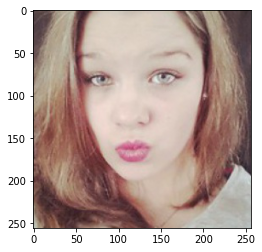

In [ ]:
import matplotlib.pyplot as plt
image,_=next(iter(trainloaderA))
print(image.shape)
plt.imshow(image[0].numpy().transpose(1,2,0))